In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
from scipy.optimize import minimize
from scipy import stats
from sklearn.utils import resample

In [2]:
!pip install yfinance
import yfinance as yf

In [3]:
!pip install pandas_datareader
import pandas_datareader.data as web

In [4]:
#stock data
aapl = yf.download("AAPL", start="2021-01-01", end="2025-01-01")
msft = yf.download("MSFT", start="2021-01-01", end="2025-01-01")
meta = yf.download("META", start="2021-01-01", end="2025-01-01")
goog = yf.download("GOOG", start="2021-01-01", end="2025-01-01")
sp500 = yf.download("^GSPC", start="2021-01-01", end="2025-01-01")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
#other data
start = datetime.datetime(2021, 1, 1)
end = datetime.datetime(2025,1,1)
#3 month t bill always consider as tisk free rate
t_bill_3m = web.DataReader("DGS3MO", "fred", start, end)

In [6]:
t_bill_3m.rename(columns={'DGS3MO': 'T3M'}, inplace=True)
#I assume 1 year have 252 trade day
t_bill_3m['daily_rf'] = t_bill_3m['T3M'] / 252 / 100

In [7]:
named_data = {
    'AAPL': aapl,
    'MSFT': msft,
    'META': meta,
    'GOOG': goog,
    'SP500': sp500
}

for df in named_data.values():
    df.columns = df.columns.droplevel(0)
    df.reset_index(inplace=True)
    df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']

In [8]:
for name, df in named_data.items():
    df['Return'] = df['Close'].pct_change()
    df['LogReturn'] = np.log(df['Close'] / df['Close'].shift(1))
    df['MA_10'] = df['Close'].rolling(window=10).mean()      
    df['Volatility_10'] = df['Return'].rolling(window=10).std()
    df = df.merge(t_bill_3m[['daily_rf']], left_on='Date', right_index=True, how='left')
    named_data[name] = df

#python这破df和dict就离谱。 .items只是引用，害得我还要重新保存一遍
aapl = named_data["AAPL"]
msft = named_data["MSFT"]
meta = named_data["META"]
goog = named_data["GOOG"]

In [9]:
#data distribution
for name,df in named_data.items():
    print(f'The disttion of {name} is:\n{df.iloc[:,1:].describe()}') 

The disttion of AAPL is:
             Close         High          Low         Open        Volume  \
count  1005.000000  1005.000000  1005.000000  1005.000000  1.005000e+03   
mean    167.116123   168.708799   165.332321   166.941294  7.370949e+07   
std      31.465292    31.504694    31.313452    31.383444  3.018616e+07   
min     113.828079   117.780174   113.681342   116.439981  2.323470e+07   
25%     143.520432   145.181976   142.010644   143.329148  5.223810e+07   
50%     163.976349   166.193981   162.847729   164.431754  6.802880e+07   
75%     184.035065   185.438641   182.434685   183.951553  8.859800e+07   
max     258.735504   259.814335   257.347047   257.906429  3.186799e+08   

            Return    LogReturn       MA_10  Volatility_10      daily_rf  
count  1004.000000  1004.000000  996.000000     995.000000  9.980000e+02  
mean      0.000820     0.000680  166.906584       0.015537  1.248767e-04  
std       0.016754     0.016730   30.752423       0.006425  9.316843e-05  

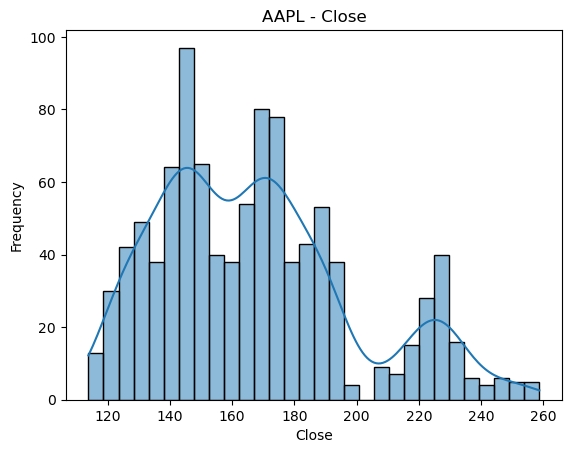

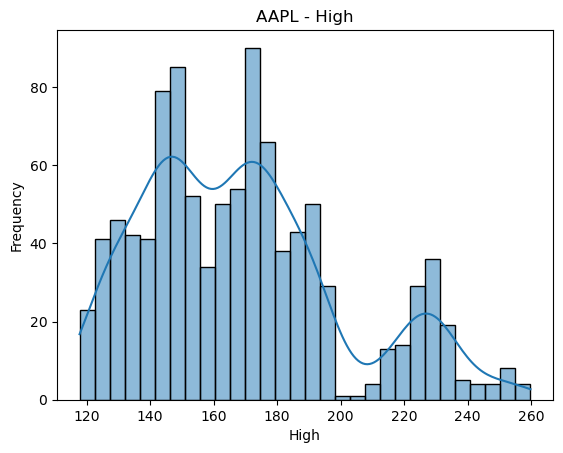

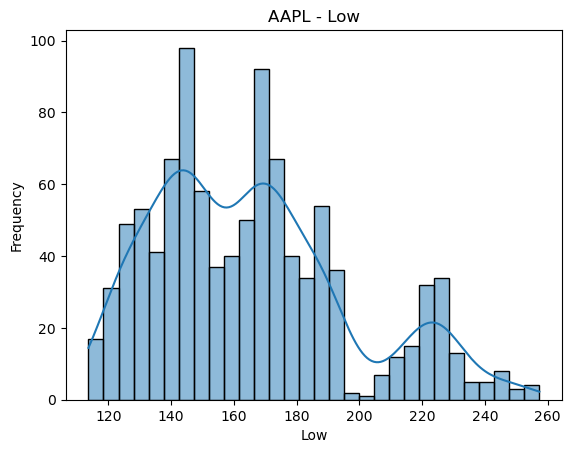

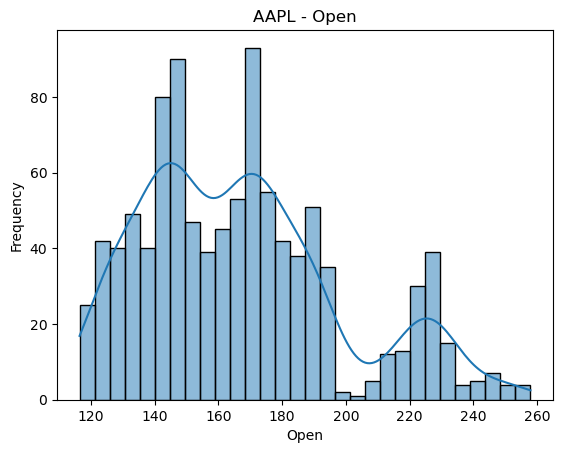

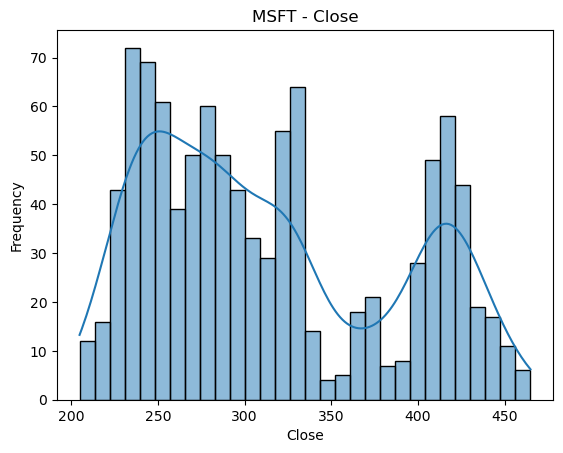

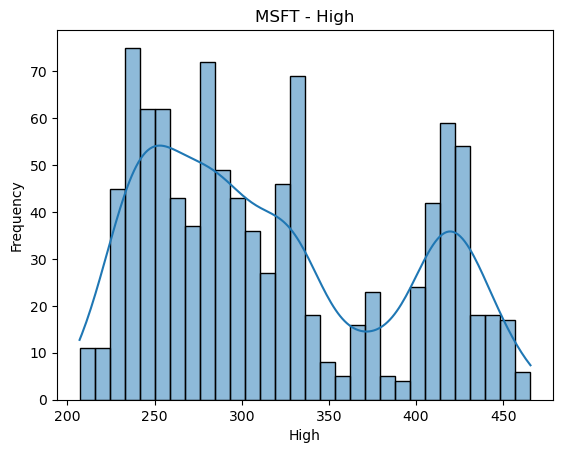

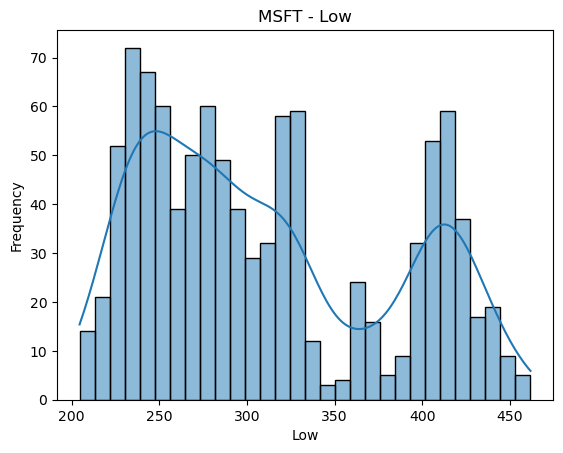

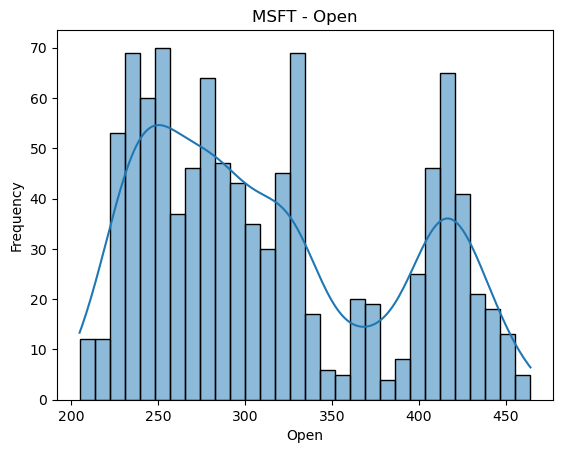

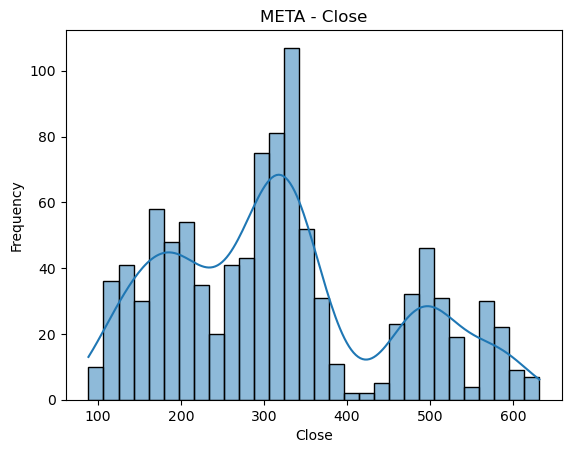

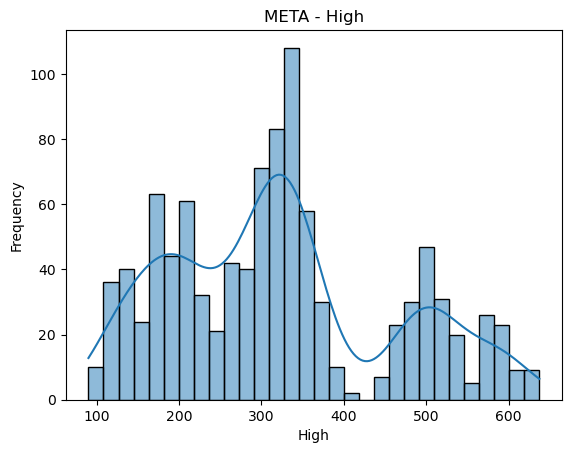

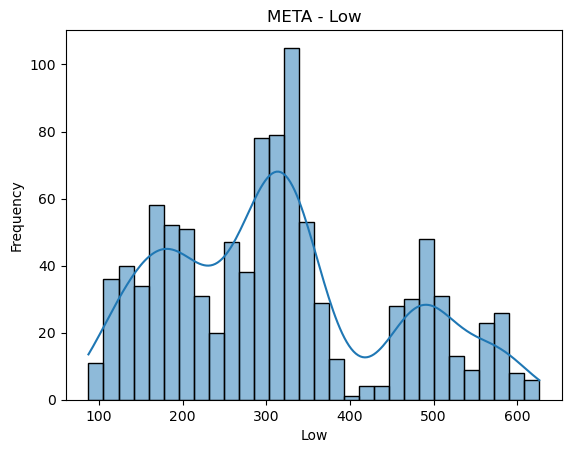

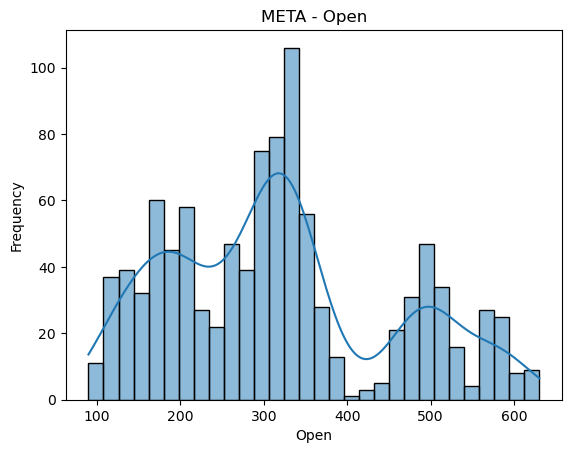

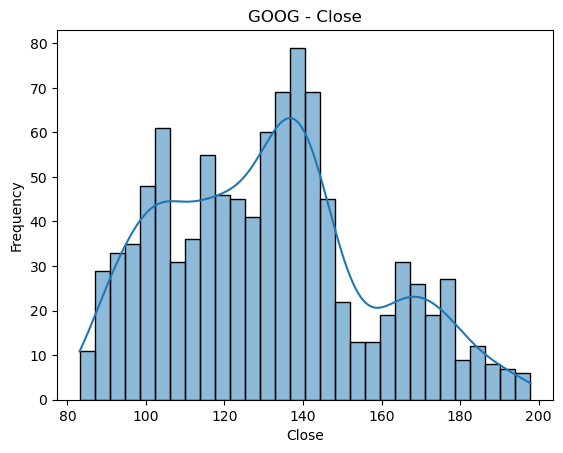

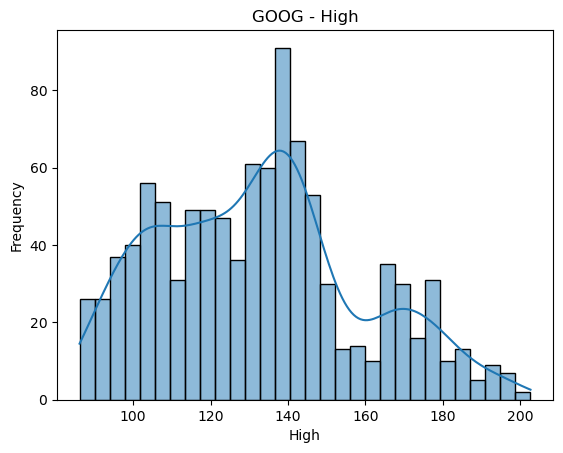

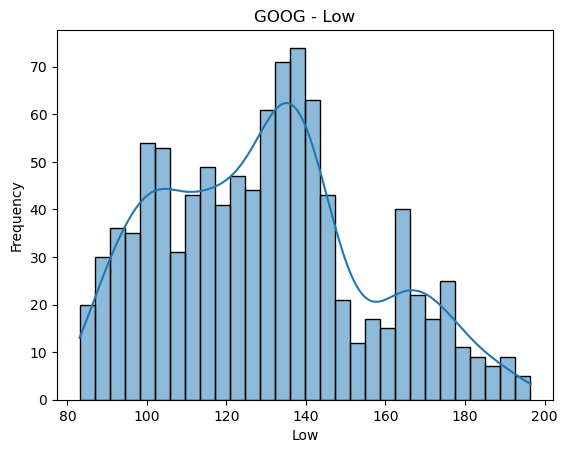

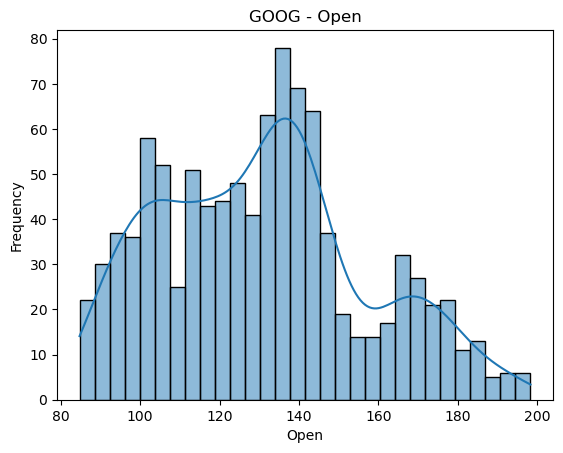

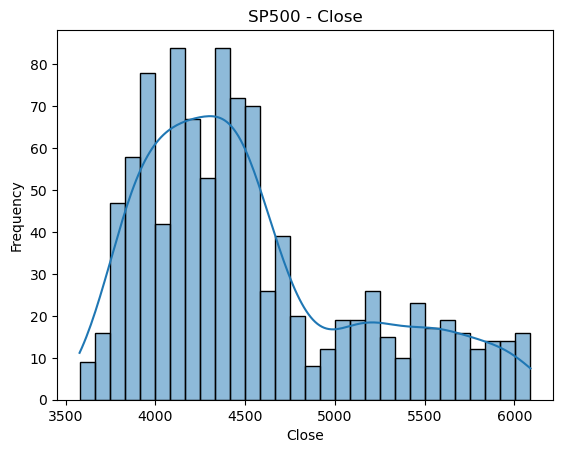

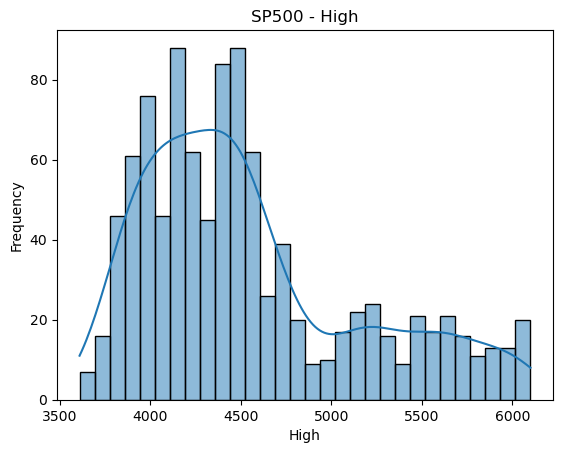

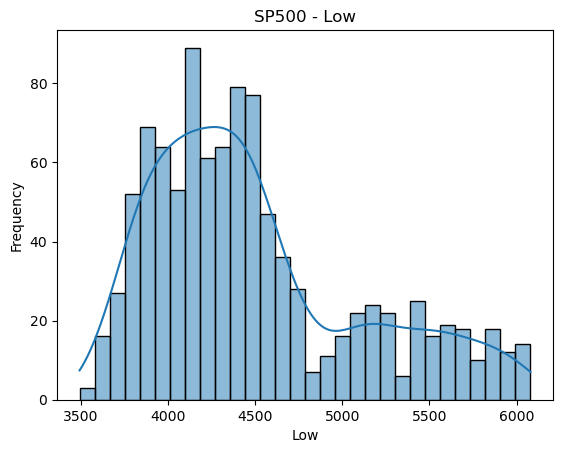

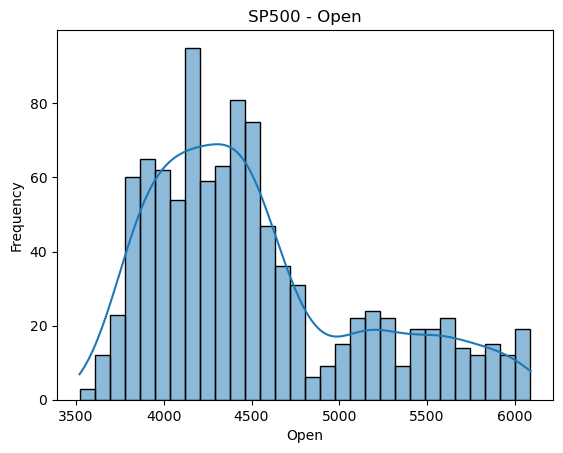

In [10]:
col_names = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
for name, df in named_data.items():
    for i in col_names[1:5]:
        sns.histplot(df[i], bins=30, kde=True)
        plt.title(f"{name} - {i}")
        plt.xlabel(i)
        plt.ylabel("Frequency")
        plt.show()

In [11]:
#sharpe ratio 
def sharpe_ratio_calc(returns, risk_free_rate=0.0):
    excess_return = returns - risk_free_rate
    return np.mean(excess_return) / np.std(excess_return)

In [12]:
sharpe_ratio = {}
for name,df in named_data.items():
    sharpe_ratio_calc
    sharpe_ratio_result = sharpe_ratio_calc(df["Return"],df["daily_rf"])
    sharpe_ratio[name] = sharpe_ratio_result

In [13]:
sharpe_ratio

{'AAPL': 0.0397575644986376,
 'MSFT': 0.042893546321110816,
 'META': 0.037757951309989185,
 'GOOG': 0.04232544624639592,
 'SP500': 0.03688255217058562}

In [14]:
#beta
beta_real = {}
for name,df in named_data.items():
    aligned = pd.concat([
        df['Return'],
        named_data['SP500']['Return']
    ], axis=1).dropna()
    aligned.columns = ['aapl_ret', 'sp500_ret']
    
    cov = np.cov(aligned['aapl_ret'], aligned['sp500_ret'])[0, 1]
    var_market = np.var(aligned['sp500_ret'])
    beta_result = cov / var_market
    beta_real[name] = beta_result

In [15]:
beta_real
#beta of market(sp500) close to 1 means our method used to approx beta is correct

{'AAPL': 1.2281485103251566,
 'MSFT': 1.23379181142699,
 'META': 1.6563925805119692,
 'GOOG': 1.3266771965899986,
 'SP500': 1.0009970089730795}

In [16]:
#CAPM.(maybe compare with Fama-French late ?)
#CAPM beta
beta_capm = {}
market_return_annual = named_data['SP500']['Return'].mean() * 252
rf_annual = t_bill_3m['T3M'].mean() / 100 
stock_return_annual = {}
for name,df in named_data.items():   
    stock_return_annual_val = df['Return'].mean() * 252  
    beta_capm_result = (stock_return_annual_val - rf_annual) / (market_return_annual - rf_annual)
    beta_capm[name] = beta_capm_result
    # I need use this for SML plot
    stock_return_annual[name] = stock_return_annual_val

In [17]:
beta_capm

{'AAPL': 1.779251327399424,
 'MSFT': 1.7969376232903238,
 'META': 2.7023434983079797,
 'GOOG': 2.184225837290493,
 'SP500': 1.0}

In [18]:
for (name1, df1), (name2, df2) in zip(beta_real.items(), beta_capm.items()):
    if name1 == "SP500":
        break
    if(df1 < df2):
        print(f'The stock of {name1} is LESS volatile than the CAPM model predicts. The stock of {name1} may be more stable or less affected by market fluctuations.')
    elif (df1 > df2):
        print(f'The stock of {name1} is MORE volatile than the CAPM model predicts. The stock of {name1} may be less stable in the real world than the prediction of CAPM.')
    else:
         print(f'[{name1}] has beta aligned with CAPM. CAPM perfect predict the model')

The stock of AAPL is LESS volatile than the CAPM model predicts. The stock of AAPL may be more stable or less affected by market fluctuations.
The stock of MSFT is LESS volatile than the CAPM model predicts. The stock of MSFT may be more stable or less affected by market fluctuations.
The stock of META is LESS volatile than the CAPM model predicts. The stock of META may be more stable or less affected by market fluctuations.
The stock of GOOG is LESS volatile than the CAPM model predicts. The stock of GOOG may be more stable or less affected by market fluctuations.


In [19]:
df_return = pd.concat([
        aapl['Return'],
        msft['Return'],
        meta['Return'],
        goog['Return']
    ], axis=1).dropna()
df_return.columns = ['AAPL','MSFT','META','GOOG']

In [20]:
#MVP
mean_returns = df_return.mean()
cov_matrix = df_return.cov()
n_assets = df_return.shape[1]
init_guess = np.ones(n_assets) / n_assets
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = tuple((0, 1) for _ in range(n_assets))

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

result_MVP = minimize(portfolio_volatility, init_guess,
                  args=(cov_matrix,), method='SLSQP',
                  bounds=bounds, constraints=constraints)

mvp_weights = result_MVP.x
mvp_return = np.dot(mvp_weights, mean_returns) * 252
mvp_vol = portfolio_volatility(mvp_weights, cov_matrix) * np.sqrt(252)

MVP_pf ={
    'Weights': pd.Series(mvp_weights, index=df_return.columns).round(4).to_dict(),
    'Return': mvp_return,
    'Volatility': mvp_vol
    }

In [21]:
MVP_pf

{'Weights': {'AAPL': 0.4564, 'MSFT': 0.4231, 'META': 0.0, 'GOOG': 0.1205},
 'Return': 0.21218594384907666,
 'Volatility': 0.24009725662931455}

In [22]:
#sharp
#since scipy does not have optimize.maximize()
rf_daily = t_bill_3m['daily_rf'].mean()

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, rf):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (portfolio_return - rf) / portfolio_vol
    return -sharpe
result_SR = minimize(neg_sharpe_ratio, init_guess,
                      args=(mean_returns, cov_matrix, rf_daily),
                      method='SLSQP', bounds=bounds, constraints=constraints)


SR_weights = result_SR.x
SR_return = np.dot(SR_weights, mean_returns) * 252
SR_vol = np.sqrt(np.dot(SR_weights.T, np.dot(cov_matrix, SR_weights))) * np.sqrt(252)
SR_sharpe = (SR_return - rf_daily * 252) / SR_vol

SR_pf ={
    'Weights': pd.Series(SR_weights, index=df_return.columns).round(4).to_dict(),
    'Return': SR_return,
    'Volatility': SR_vol
    }

In [23]:
SR_pf

{'Weights': {'AAPL': 0.3014, 'MSFT': 0.2681, 'META': 0.1276, 'GOOG': 0.3029},
 'Return': 0.23078488977642314,
 'Volatility': 0.2538190641954698}

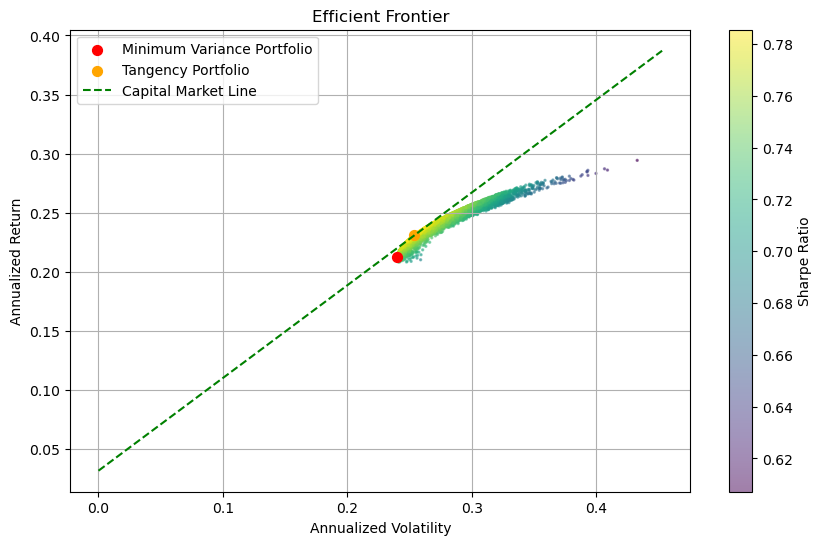

In [24]:
#CML
n_portfolios = 10000
n_assets = df_return.shape[1]
results = np.zeros((3, n_portfolios))

for i in range(n_portfolios):
    weights = np.random.random(n_assets)
    weights /= np.sum(weights)
    
    port_return = np.dot(weights, mean_returns) * 252
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    sharpe = (port_return - rf_daily * 252) / port_vol
    
    results[0,i] = port_vol
    results[1,i] = port_return
    results[2,i] = sharpe


mvp_return = np.dot(mvp_weights, mean_returns) * 252
mvp_vol = np.sqrt(np.dot(mvp_weights.T, np.dot(cov_matrix, mvp_weights))) * np.sqrt(252)

SR_return = np.dot(SR_weights, mean_returns) * 252
SR_vol = np.sqrt(np.dot(SR_weights.T, np.dot(cov_matrix, SR_weights))) * np.sqrt(252)

cml_x = np.linspace(0, max(results[0]) + 0.02, 100)
cml_y = rf_daily * 252 + ((SR_return - rf_daily * 252) / SR_vol) * cml_x

plt.figure(figsize=(10,6))
plt.scatter(results[0], results[1], c=results[2], cmap='viridis', s=2, alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
#MVP and Tangency points
plt.scatter(mvp_vol, mvp_return, color='red', marker='o', s=50, label='Minimum Variance Portfolio')
plt.scatter(SR_vol, SR_return, color='orange', marker='o', s=50, label='Tangency Portfolio')
#CML
plt.plot(cml_x, cml_y, color='green', linestyle='--', label='Capital Market Line')

plt.title('Efficient Frontier')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.legend()
plt.grid(True)
plt.show()

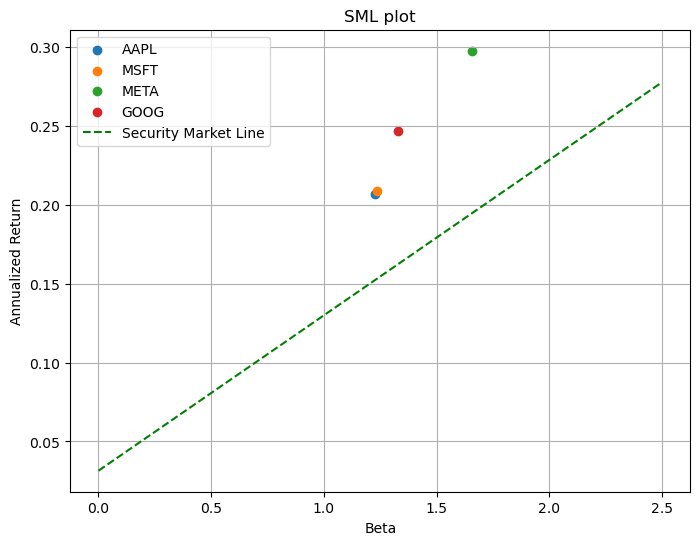

In [25]:
#SML
beta_range = np.linspace(0, 2.5, 100)
sml_line = rf_annual + beta_range * (market_return_annual - rf_annual)

plt.figure(figsize=(8,6))
for name in beta_real:
    if name == 'SP500': continue 
    plt.scatter(beta_real[name], stock_return_annual[name], label=name)

plt.plot(beta_range, sml_line, color='green', linestyle='--', label='Security Market Line')
plt.title('SML plot')
plt.xlabel('Beta')
plt.ylabel('Annualized Return')
plt.legend()
plt.grid(True)
plt.show()

Risk Metrics
       Volatility  VaR (5%)
Stock                      
AAPL     0.019509 -0.029801
GOOG     0.016038 -0.023738
META     0.022287 -0.036945
MSFT     0.017675 -0.026890


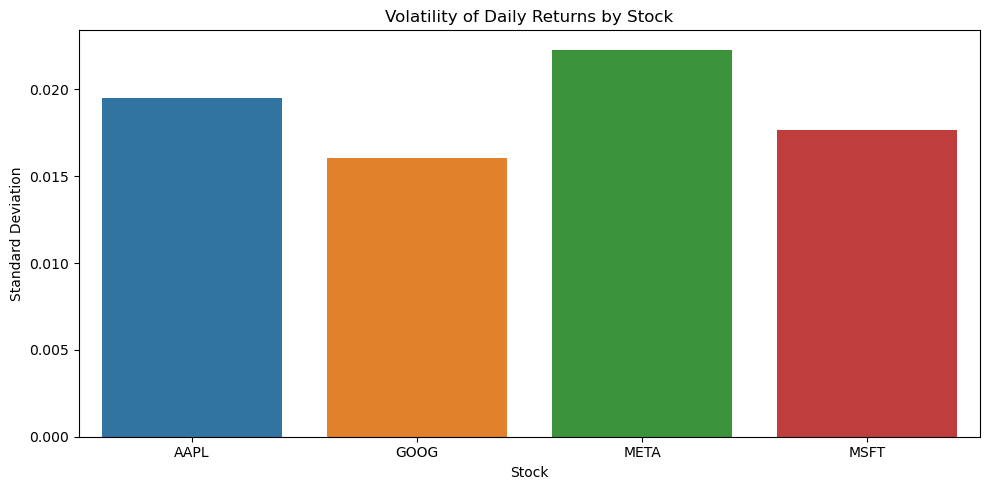

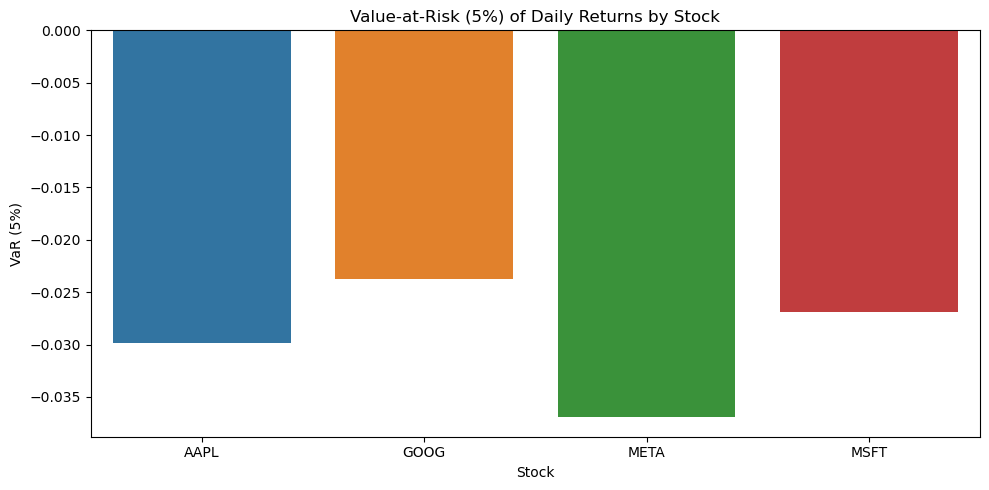

In [26]:
dates = pd.date_range(start="2021-01-01", end="2021-12-31", freq="B")
np.random.seed(42)
stock_data = {
    "AAPL": pd.DataFrame({"Date": dates, "Close": np.cumprod(1 + np.random.normal(0.0005, 0.02, len(dates)))}),
    "MSFT": pd.DataFrame({"Date": dates, "Close": np.cumprod(1 + np.random.normal(0.0004, 0.018, len(dates)))}),
    "META": pd.DataFrame({"Date": dates, "Close": np.cumprod(1 + np.random.normal(0.0003, 0.022, len(dates)))}),
    "GOOG": pd.DataFrame({"Date": dates, "Close": np.cumprod(1 + np.random.normal(0.0006, 0.017, len(dates)))})
}

# Calculate daily returns
returns_data = []
for stock, df in stock_data.items():
    df["Return"] = df["Close"].pct_change()
    df["Stock"] = stock
    returns_data.append(df[["Date", "Stock", "Return"]])
returns_df = pd.concat(returns_data).dropna()

# Compute risk metrics: Volatility and VaR (5%)
risk_metrics = returns_df.groupby("Stock")["Return"].agg([
    ("Volatility", np.std),
    ("VaR (5%)", lambda x: np.percentile(x, 5))
])
print("Risk Metrics")
print(risk_metrics)

# Plot volatility
plt.figure(figsize=(10, 5))
sns.barplot(x=risk_metrics.index, y="Volatility", data=risk_metrics.reset_index())
plt.title("Volatility of Daily Returns by Stock")
plt.xlabel("Stock")
plt.ylabel("Standard Deviation")
plt.tight_layout()
plt.show()

# Plot Value-at-Risk (5%)
plt.figure(figsize=(10, 5))
sns.barplot(x=risk_metrics.index, y="VaR (5%)", data=risk_metrics.reset_index())
plt.title("Value-at-Risk (5%) of Daily Returns by Stock")
plt.xlabel("Stock")
plt.ylabel("VaR (5%)")
plt.tight_layout()
plt.show()

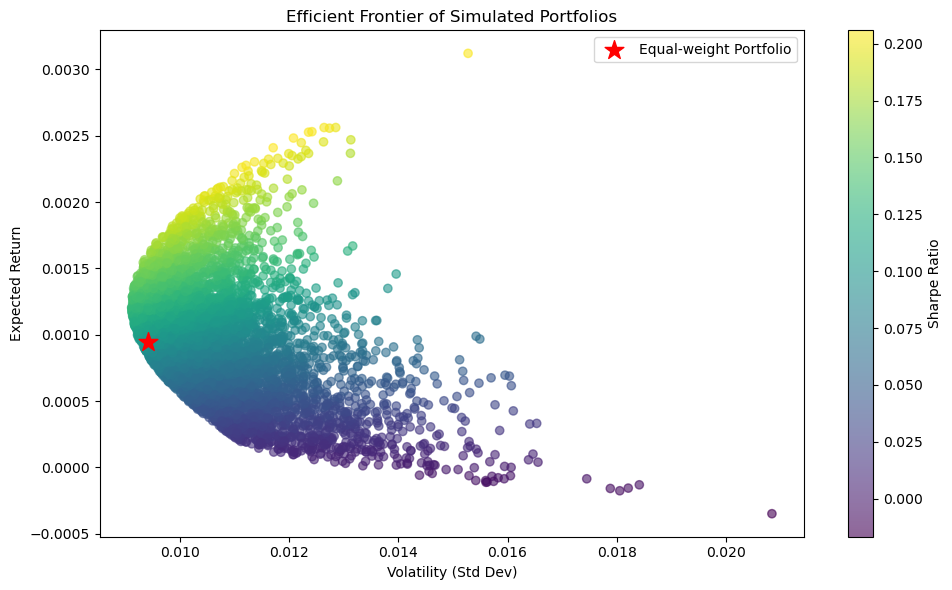

Equal-Weight Portfolio
Expected Return: 0.000945
Volatility: 0.009415
Sharpe Ratio: 0.1004


In [27]:
# Simulated daily returns
portfolio_returns = returns_df.pivot(index="Date", columns="Stock", values="Return")

# Equal-weight portfolio
weights = np.array([0.25, 0.25, 0.25, 0.25])
mean_returns = portfolio_returns.mean()
cov_matrix = portfolio_returns.cov()

portfolio_return = np.dot(weights, mean_returns)
portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
sharpe_ratio = portfolio_return / portfolio_volatility

# Simulate random portfolios
num_portfolios = 5000
results = np.zeros((3, num_portfolios))

for i in range(num_portfolios):
    w = np.random.random(4)
    w /= np.sum(w)
    port_return = np.dot(w, mean_returns)
    port_volatility = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
    port_sharpe = port_return / port_volatility
    results[0, i] = port_return
    results[1, i] = port_volatility
    results[2, i] = port_sharpe

# Plot efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', alpha=0.6)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(portfolio_volatility, portfolio_return, color='red', marker='*', s=200, label='Equal-weight Portfolio')
plt.title("Efficient Frontier of Simulated Portfolios")
plt.xlabel("Volatility (Std Dev)")
plt.ylabel("Expected Return")
plt.legend()
plt.tight_layout()
plt.show()

# Print portfolio stats
print("Equal-Weight Portfolio")
print(f"Expected Return: {portfolio_return:.6f}")
print(f"Volatility: {portfolio_volatility:.6f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

ANOVA Test Results
F-statistic: 1.8518
P-value: 0.1361



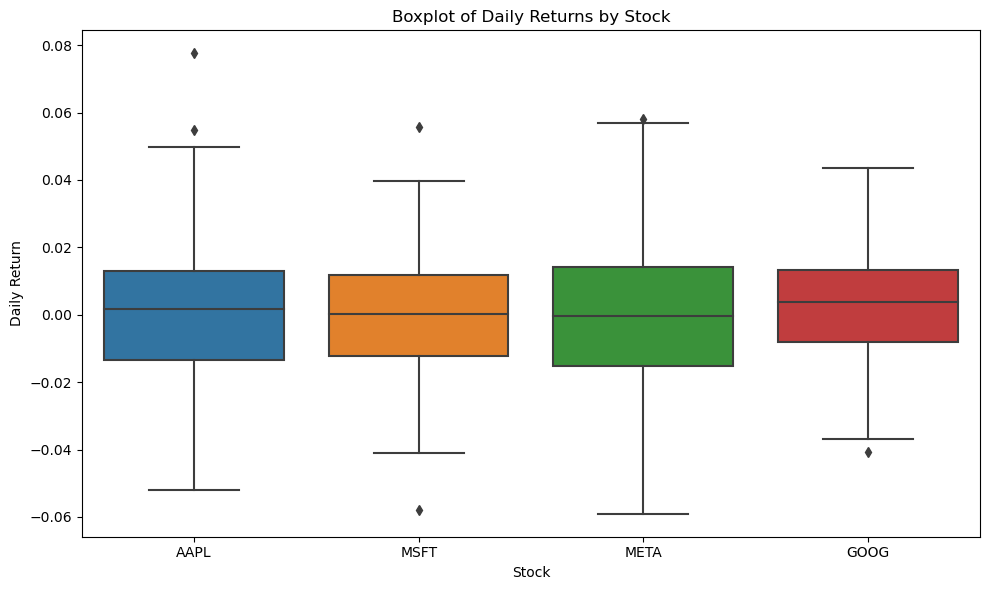

In [29]:
# ANOVA test
anova_result = stats.f_oneway(
    returns_df[returns_df["Stock"] == "AAPL"]["Return"],
    returns_df[returns_df["Stock"] == "MSFT"]["Return"],
    returns_df[returns_df["Stock"] == "META"]["Return"],
    returns_df[returns_df["Stock"] == "GOOG"]["Return"]
)

# Print ANOVA results
print("ANOVA Test Results")
print(f"F-statistic: {anova_result.statistic:.4f}")
print(f"P-value: {anova_result.pvalue:.4f}\n")

# Plot boxplot of daily returns
plt.figure(figsize=(10, 6))
sns.boxplot(x="Stock", y="Return", data=returns_df)
plt.title("Boxplot of Daily Returns by Stock")
plt.xlabel("Stock")
plt.ylabel("Daily Return")
plt.tight_layout()
plt.show()

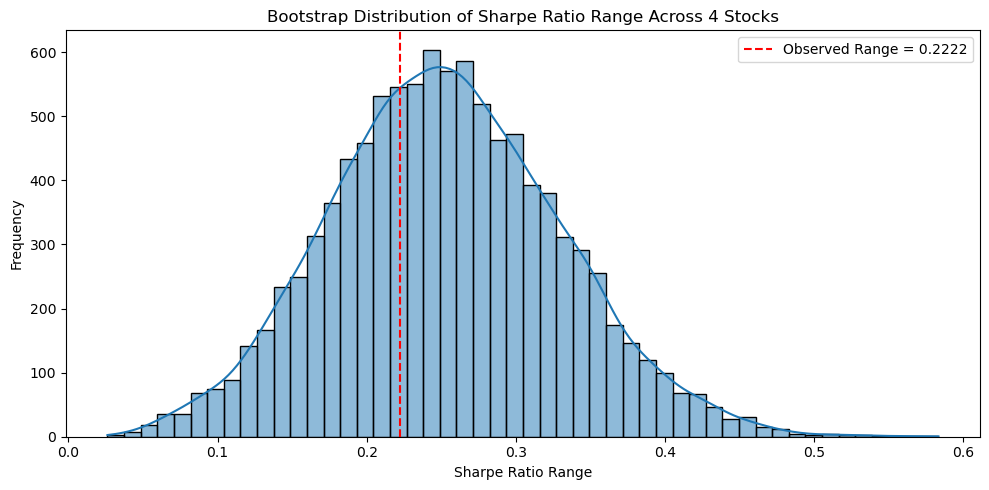

Observed Sharpe Ratios: {'AAPL': 0.02782257544155299, 'GOOG': 0.2040392726002979, 'META': -0.01811132403197914, 'MSFT': 0.020864791071122966}
Observed Sharpe Range: 0.2222
Bootstrap p-value: 0.6452


In [30]:
# Group returns by stock
observed_sharpes = returns_df.groupby("Stock").apply(lambda x: x["Return"].mean() / x["Return"].std())
observed_sharpe_range = observed_sharpes.max() - observed_sharpes.min()

# Bootstrap the range of Sharpe ratios
n_iterations = 10000
np.random.seed(42)
boot_sharpe_ranges = []

stocks = returns_df["Stock"].unique()
returns_by_stock = {stock: returns_df[returns_df["Stock"] == stock]["Return"].values for stock in stocks}

for _ in range(n_iterations):
    boot_sharpes = []
    for stock in stocks:
        sample = resample(returns_by_stock[stock])
        if np.std(sample) != 0:
            boot_sharpe = np.mean(sample) / np.std(sample)
        else:
            boot_sharpe = 0  # avoid division by zero
        boot_sharpes.append(boot_sharpe)
    boot_sharpe_ranges.append(max(boot_sharpes) - min(boot_sharpes))

# Compute p-value
p_value_range = np.mean(np.array(boot_sharpe_ranges) >= observed_sharpe_range)

# Plot result
plt.figure(figsize=(10, 5))
sns.histplot(boot_sharpe_ranges, bins=50, kde=True)
plt.axvline(observed_sharpe_range, color='red', linestyle='--', label=f'Observed Range = {observed_sharpe_range:.4f}')
plt.title("Bootstrap Distribution of Sharpe Ratio Range Across 4 Stocks")
plt.xlabel("Sharpe Ratio Range")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

# Output results
print("Observed Sharpe Ratios:", observed_sharpes.to_dict())
print(f"Observed Sharpe Range: {observed_sharpe_range:.4f}")
print(f"Bootstrap p-value: {p_value_range:.4f}")

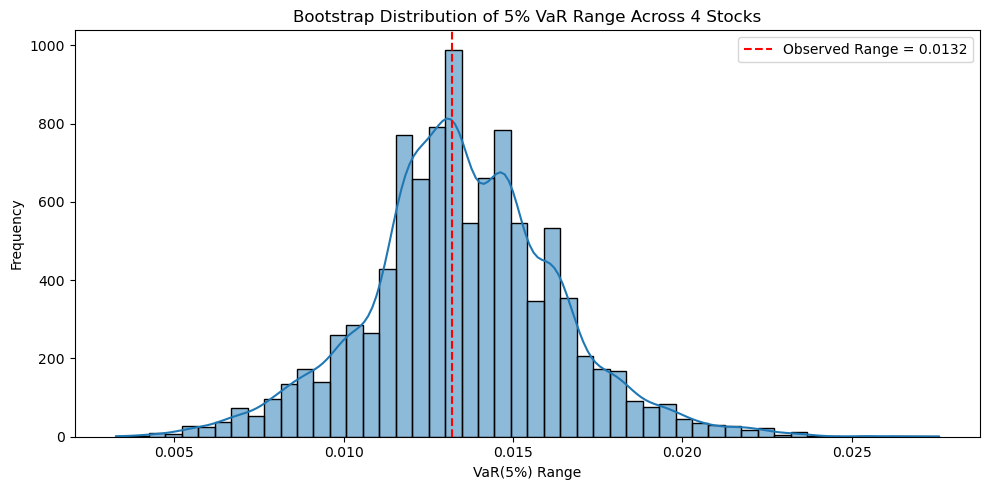

Observed VaRs: {'AAPL': -0.029801467234985436, 'GOOG': -0.02373782971456024, 'META': -0.036945352725701396, 'MSFT': -0.02689046991725732}
Observed VaR Range: 0.0132
Bootstrap p-value: 0.5383


In [31]:
# Compute observed VaRs
observed_vars = returns_df.groupby("Stock").apply(lambda x: np.percentile(x["Return"], 5))
observed_var_range = observed_vars.max() - observed_vars.min()

# Bootstrap the range of VaRs
n_iterations = 10000
np.random.seed(42)
boot_var_ranges = []

for _ in range(n_iterations):
    boot_vars = []
    for stock in stocks:
        sample = resample(returns_by_stock[stock])
        boot_var = np.percentile(sample, 5)
        boot_vars.append(boot_var)
    boot_var_ranges.append(max(boot_vars) - min(boot_vars))

# Compute p-value
p_value_var_range = np.mean(np.array(boot_var_ranges) >= observed_var_range)

# Plot result
plt.figure(figsize=(10, 5))
sns.histplot(boot_var_ranges, bins=50, kde=True)
plt.axvline(observed_var_range, color='red', linestyle='--', label=f'Observed Range = {observed_var_range:.4f}')
plt.title("Bootstrap Distribution of 5% VaR Range Across 4 Stocks")
plt.xlabel("VaR(5%) Range")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

# Output results
print("Observed VaRs:", observed_vars.to_dict())
print(f"Observed VaR Range: {observed_var_range:.4f}")
print(f"Bootstrap p-value: {p_value_var_range:.4f}")